# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

# Embedding Layer

This notebook uses Keras Embedding layer in the model to try to improve models accuracy. It allows us to convert each word into a fixed length vector of defined size. The only arguments it needs are the size of the vocabulary, the length of the vector for each word and the maximum length of a sequence. It's documentation can be found [here](https://keras.io/api/layers/core_layers/embedding/).<br />
As with other embeding techniques, little preprocessing is needed, so the cleaning stage of the data is smaller than with categorical encoding.

In [178]:
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#Preprocessing
import nltk
from nltk.collocations import *
from nltk import word_tokenize
import string

from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras import regularizers

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [127]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [129]:
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df

def drop_features(df):
    df = df[['statement','label']]
    return df

def reset_index(df):
    df['statement'] = df['statement'].apply(lambda x: x.lower())
    return df

def remove_punctuation(df):
    df['statement'] = df['statement'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
    return df

def lower_case(df):
    df = df.reset_index(drop=True)
    return df

def tokenize_(df):
    df['statement'] = df['statement'].map(word_tokenize)
    return df

In [130]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('reset_index', FunctionTransformer(reset_index)),
    ('lower_case', FunctionTransformer(lower_case)),
    ('remove_punctuation', FunctionTransformer(remove_punctuation)),
    ('tokenize_', FunctionTransformer(tokenize_))
])

In [131]:
df_train_clean = cleaning_pipeline.fit_transform(raw_train)
df_val_clean = cleaning_pipeline.transform(raw_val)
df_test_clean = cleaning_pipeline.transform(raw_test)

In [132]:
X_train_clean = df_train_clean['statement']
y_train_clean = df_train_clean['label']
X_val_clean = df_val_clean['statement']
y_val_clean = df_val_clean['label']
X_test_clean = df_test_clean['statement']
y_test_clean = df_test_clean['label']

In [134]:
df_train_clean.head()

,statement,label
0,"[says, the, annies, list, political, group, su...",0
1,"[when, did, the, decline, of, coal, start, it,...",1
2,"[hillary, clinton, agrees, with, john, mccain,...",1
3,"[health, care, reform, legislation, is, likely...",0
4,"[the, economic, turnaround, started, at, the, ...",1


In [146]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in ' '.join(text).split():
            count[word] += 1
    return count
counter = counter_word(df_train_clean['statement'])
num_unique_words = len(counter)
print(num_unique_words)

13453


In [137]:
# Transform Series into Numpy arrays
train_text = df_train_clean['statement'].to_numpy()
train_labels = df_train_clean['label'].to_numpy()
val_text = df_val_clean['statement'].to_numpy()
val_labels = df_val_clean['label'].to_numpy()
test_text = df_test_clean['statement'].to_numpy()
test_labels = df_test_clean['label'].to_numpy()

In [138]:
train_text.shape, val_text.shape, test_text.shape

((10240,), (1284,), (1267,))

In [149]:
# Tokenize
# Vectorize a corpus turning text into sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_text)

In [150]:
# Gives value for every word (key) in a dictionary
word_index = tokenizer.word_index

In [151]:
list(word_index.items())[:5]

[('the', 1), ('in', 2), ('of', 3), ('to', 4), ('a', 5)]

In [152]:
# Transform word sentences in lists of numbers
train_sequences = tokenizer.texts_to_sequences(train_text)
val_sequences = tokenizer.texts_to_sequences(val_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

In [153]:
train_sequences[:5]

[[7, 1, 7130, 1111, 508, 596, 364, 5155, 558, 11, 1563],
 [60,
  152,
  1,
  2069,
  3,
  1062,
  907,
  23,
  597,
  60,
  1112,
  304,
  173,
  233,
  9,
  597,
  4,
  1792,
  2,
  33,
  294,
  598,
  1063,
  166],
 [120,
  96,
  3528,
  24,
  183,
  251,
  20,
  321,
  4,
  327,
  294,
  167,
  1,
  1064,
  3,
  1,
  3529,
  11,
  381],
 [31, 43, 258, 281, 10, 634, 4, 646, 432, 647, 389, 4142],
 [1, 311, 4143, 597, 37, 1, 401, 3, 164, 617]]

In [155]:
# Pad the sequences to have the same length
# Max number of words in a sequence
max_length = 15

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_padded.shape, val_padded.shape, test_padded.shape

((10240, 15), (1284, 15), (1267, 15))

In [156]:
train_padded[:5]

array([[   7,    1, 7130, 1111,  508,  596,  364, 5155,  558,   11, 1563,
           0,    0,    0,    0],
       [  60,  152,    1, 2069,    3, 1062,  907,   23,  597,   60, 1112,
         304,  173,  233,    9],
       [ 120,   96, 3528,   24,  183,  251,   20,  321,    4,  327,  294,
         167,    1, 1064,    3],
       [  31,   43,  258,  281,   10,  634,    4,  646,  432,  647,  389,
        4142,    0,    0,    0],
       [   1,  311, 4143,  597,   37,    1,  401,    3,  164,  617,    0,
           0,    0,    0,    0]])

In [157]:
# Check reversing the indicies
# flip key, value
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [158]:
def decode(sequence):
    return ' '.join([reverse_word_index.get(idx, '?') for idx in sequence])

In [159]:
decoded_text = decode(train_sequences[10])

In [160]:
print(train_sequences[10])
decoded_text

[8, 1, 97, 102, 2, 180, 1, 1114, 3, 1, 131, 872, 159, 1795, 10, 1345, 16, 1, 2072, 159, 1795]


'for the first time in history the share of the national popular vote margin is smaller than the latino vote margin'

In [162]:
# Ohe label values
labels_train = np.zeros((len(train_labels), train_labels.max()+1))
labels_val = np.zeros((len(val_labels), val_labels.max()+1))
labels_test = np.zeros((len(test_labels), val_labels.max()+1))

labels_train[np.arange(len(train_labels)), train_labels] = 1
labels_val[np.arange(len(val_labels)), val_labels] = 1
labels_test[np.arange(len(test_labels)), test_labels] = 1

## Neural Networks

In [171]:
input_ = Input(shape=(15)) # shape from train_data
embedded = Embedding(len(vocabulary_dict)*10, 100, input_length=len(vocabulary_dict))(input_)
lstm = LSTM(100)(embedded)
dense = Dense(2, activation='sigmoid')(lstm) 

model_keras_tok_1 = Model(input_, dense)
model_keras_tok_1.layers[1].trainable = False
model_keras_tok_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_18 (Embedding)    (None, 15, 100)           12443000  
                                                                 
 lstm_16 (LSTM)              (None, 100)               80400     
                                                                 
 dense_21 (Dense)            (None, 2)                 202       
                                                                 
Total params: 12,523,602
Trainable params: 80,602
Non-trainable params: 12,443,000
_________________________________________________________________


In [172]:
loss = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam()
metrics = ['accuracy']

model_keras_tok_1.compile(loss=loss, optimizer=optim, metrics=metrics)

In [173]:
history_keras_tok_1 = model_keras_tok_1.fit(train_padded, labels_train, epochs=30, validation_data=(val_padded, labels_val), verbose=2)

Epoch 1/30
320/320 - 8s - loss: 0.6840 - accuracy: 0.5588 - val_loss: 0.7272 - val_accuracy: 0.5428 - 8s/epoch - 26ms/step
Epoch 2/30
320/320 - 3s - loss: 0.6778 - accuracy: 0.5752 - val_loss: 0.6831 - val_accuracy: 0.5498 - 3s/epoch - 9ms/step
Epoch 3/30
320/320 - 3s - loss: 0.6738 - accuracy: 0.5842 - val_loss: 0.6768 - val_accuracy: 0.5724 - 3s/epoch - 9ms/step
Epoch 4/30
320/320 - 3s - loss: 0.6706 - accuracy: 0.5827 - val_loss: 0.6716 - val_accuracy: 0.5857 - 3s/epoch - 9ms/step
Epoch 5/30
320/320 - 3s - loss: 0.6682 - accuracy: 0.5916 - val_loss: 0.6766 - val_accuracy: 0.5701 - 3s/epoch - 9ms/step
Epoch 6/30
320/320 - 3s - loss: 0.6653 - accuracy: 0.5951 - val_loss: 0.6789 - val_accuracy: 0.5670 - 3s/epoch - 9ms/step
Epoch 7/30
320/320 - 3s - loss: 0.6634 - accuracy: 0.5979 - val_loss: 0.6840 - val_accuracy: 0.5623 - 3s/epoch - 10ms/step
Epoch 8/30
320/320 - 3s - loss: 0.6612 - accuracy: 0.6019 - val_loss: 0.6788 - val_accuracy: 0.5631 - 3s/epoch - 9ms/step
Epoch 9/30
320/320 - 3

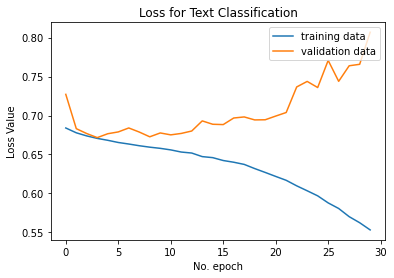

In [174]:
plt.plot(history_keras_tok_1.history['loss'], label='training data')
plt.plot(history_keras_tok_1.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

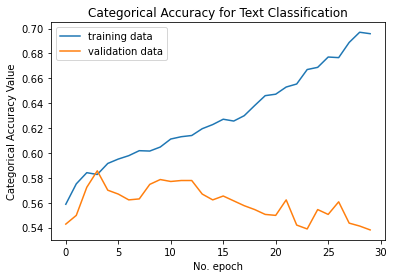

In [175]:
plt.plot(history_keras_tok_1.history['accuracy'], label='training data')
plt.plot(history_keras_tok_1.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [179]:
input_2 = Input(shape=(15))
embedded_2 = Embedding(len(vocabulary_dict)*10, 100, input_length=len(vocabulary_dict))(input_2)
lstm_2 = LSTM(100)(embedded_2)
reg_2 = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05))(lstm_2)
dense_2 = Dense(2, activation='sigmoid')(reg_2) 

In [180]:
model_keras_tok_2 = Model(input_2, dense_2)
model_keras_tok_2.layers[1].trainable = False
model_keras_tok_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_20 (Embedding)    (None, 15, 100)           12443000  
                                                                 
 lstm_18 (LSTM)              (None, 100)               80400     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 2)                 202       
                                                                 
Total params: 12,533,702
Trainable params: 90,702
Non-trainable params: 12,443,000
_________________________________________________________________


In [181]:
model_keras_tok_2.compile(loss=loss, optimizer=optim, metrics=metrics)

In [182]:
history_keras_tok_2 = model_keras_tok_2.fit(train_padded, labels_train, epochs=30, validation_data=(val_padded, labels_val), verbose=2)

Epoch 1/30
320/320 - 6s - loss: 0.8285 - accuracy: 0.5602 - val_loss: 0.7055 - val_accuracy: 0.5202 - 6s/epoch - 20ms/step
Epoch 2/30
320/320 - 3s - loss: 0.6858 - accuracy: 0.5617 - val_loss: 0.6951 - val_accuracy: 0.5202 - 3s/epoch - 8ms/step
Epoch 3/30
320/320 - 3s - loss: 0.6873 - accuracy: 0.5617 - val_loss: 0.6945 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 4/30
320/320 - 3s - loss: 0.6865 - accuracy: 0.5617 - val_loss: 0.6944 - val_accuracy: 0.5202 - 3s/epoch - 8ms/step
Epoch 5/30
320/320 - 3s - loss: 0.6860 - accuracy: 0.5617 - val_loss: 0.6982 - val_accuracy: 0.5202 - 3s/epoch - 8ms/step
Epoch 6/30
320/320 - 3s - loss: 0.6850 - accuracy: 0.5617 - val_loss: 0.7007 - val_accuracy: 0.5202 - 3s/epoch - 8ms/step
Epoch 7/30
320/320 - 3s - loss: 0.6851 - accuracy: 0.5617 - val_loss: 0.6951 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 8/30
320/320 - 3s - loss: 0.6839 - accuracy: 0.5617 - val_loss: 0.6952 - val_accuracy: 0.5202 - 3s/epoch - 8ms/step
Epoch 9/30
320/320 - 3s

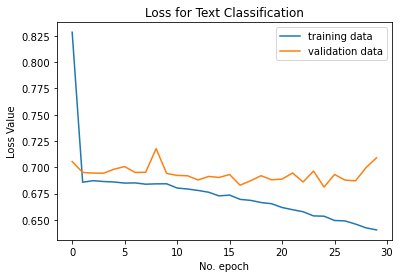

In [183]:
plt.plot(history_keras_tok_2.history['loss'], label='training data')
plt.plot(history_keras_tok_2.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

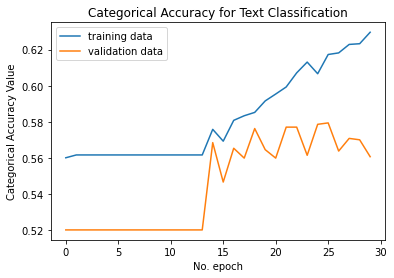

In [184]:
plt.plot(history_keras_tok_2.history['accuracy'], label='training data')
plt.plot(history_keras_tok_2.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [185]:
input_3 = Input(shape=(15)) # shape from train_data
embedded_3 = Embedding(len(vocabulary_dict)*10, 100, input_length=len(vocabulary_dict))(input_3)
lstm_3 = LSTM(100)(embedded_3)
drop_3 = Dropout(0.1)(lstm_3)
reg_3 = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05))(drop_3)
dense_3 = Dense(2, activation='sigmoid')(reg_3) 

In [186]:
model_keras_tok_3 = Model(input_3, dense_3)
model_keras_tok_3.layers[1].trainable = False
model_keras_tok_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_21 (Embedding)    (None, 15, 100)           12443000  
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dense_25 (Dense)            (None, 2)                 202       
                                                                 
Total params: 12,533,702
Trainable params: 90,702
Non-train

In [187]:
model_keras_tok_3.compile(loss=loss, optimizer=optim, metrics=metrics)

In [188]:
history_keras_tok_3 = model_keras_tok_3.fit(train_padded, labels_train, epochs=30, validation_data=(val_padded, labels_val), verbose=2)

Epoch 1/30
320/320 - 7s - loss: 0.8276 - accuracy: 0.5610 - val_loss: 0.6980 - val_accuracy: 0.5202 - 7s/epoch - 23ms/step
Epoch 2/30
320/320 - 3s - loss: 0.6850 - accuracy: 0.5617 - val_loss: 0.6925 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 3/30
320/320 - 3s - loss: 0.6874 - accuracy: 0.5617 - val_loss: 0.6965 - val_accuracy: 0.5202 - 3s/epoch - 10ms/step
Epoch 4/30
320/320 - 3s - loss: 0.6862 - accuracy: 0.5617 - val_loss: 0.7106 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 5/30
320/320 - 3s - loss: 0.6837 - accuracy: 0.5617 - val_loss: 0.7108 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 6/30
320/320 - 3s - loss: 0.6805 - accuracy: 0.5617 - val_loss: 0.6862 - val_accuracy: 0.5202 - 3s/epoch - 9ms/step
Epoch 7/30
320/320 - 3s - loss: 0.6776 - accuracy: 0.5633 - val_loss: 0.6809 - val_accuracy: 0.5942 - 3s/epoch - 9ms/step
Epoch 8/30
320/320 - 3s - loss: 0.6773 - accuracy: 0.5708 - val_loss: 0.6857 - val_accuracy: 0.5833 - 3s/epoch - 9ms/step
Epoch 9/30
320/320 - 3

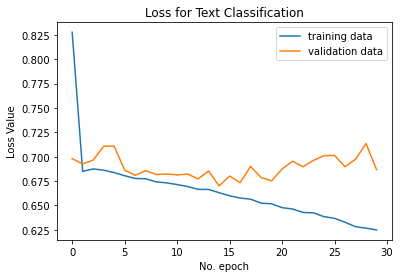

In [189]:
plt.plot(history_keras_tok_3.history['loss'], label='training data')
plt.plot(history_keras_tok_3.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

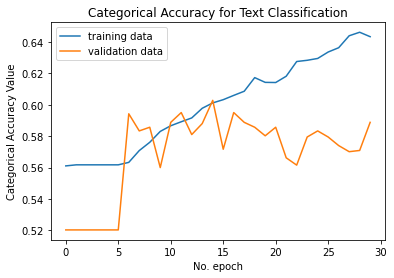

In [190]:
plt.plot(history_keras_tok_3.history['accuracy'], label='training data')
plt.plot(history_keras_tok_3.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [248]:
input_4 = Input(shape=(15)) # shape from train_data
embedded_4 = Embedding(len(vocabulary_dict)*10, 100, input_length=len(vocabulary_dict))(input_4)
lstm_4 = Bidirectional(LSTM(100))(embedded_4)
drop_4 = Dropout(0.1)(lstm_4)
reg_4 = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05))(drop_4)
dense_4 = Dense(2, activation='sigmoid')(reg_4) 

In [249]:
model_keras_tok_4 = Model(input_4, dense_4)
model_keras_tok_4.layers[1].trainable = False
model_keras_tok_4.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_24 (Embedding)    (None, 15, 100)           12443000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_36 (Dense)            (None, 100)               20100     
                                                                 
 dense_37 (Dense)            (None, 2)                 202       
                                                           

In [250]:
model_keras_tok_4.compile(loss=loss, optimizer=optim, metrics=metrics)
history_keras_tok_4 = model_keras_tok_4.fit(train_padded, labels_train, epochs=30, validation_data=(val_padded, labels_val), verbose=2)

Epoch 1/30
320/320 - 48s - loss: 0.8510 - accuracy: 0.5594 - val_loss: 0.7032 - val_accuracy: 0.5202 - 48s/epoch - 151ms/step
Epoch 2/30
320/320 - 5s - loss: 0.6869 - accuracy: 0.5617 - val_loss: 0.6947 - val_accuracy: 0.5202 - 5s/epoch - 14ms/step
Epoch 3/30
320/320 - 4s - loss: 0.6852 - accuracy: 0.5617 - val_loss: 0.6935 - val_accuracy: 0.5202 - 4s/epoch - 11ms/step
Epoch 4/30
320/320 - 4s - loss: 0.6855 - accuracy: 0.5617 - val_loss: 0.6960 - val_accuracy: 0.5202 - 4s/epoch - 12ms/step
Epoch 5/30
320/320 - 4s - loss: 0.6865 - accuracy: 0.5617 - val_loss: 0.6917 - val_accuracy: 0.5202 - 4s/epoch - 12ms/step
Epoch 6/30
320/320 - 4s - loss: 0.6828 - accuracy: 0.5617 - val_loss: 0.6932 - val_accuracy: 0.5202 - 4s/epoch - 12ms/step
Epoch 7/30
320/320 - 4s - loss: 0.6822 - accuracy: 0.5617 - val_loss: 0.6907 - val_accuracy: 0.5202 - 4s/epoch - 11ms/step
Epoch 8/30
320/320 - 4s - loss: 0.6819 - accuracy: 0.5617 - val_loss: 0.6900 - val_accuracy: 0.5202 - 4s/epoch - 12ms/step
Epoch 9/30
32

Check on predictions for last trained model:

In [251]:
predictions = model_keras_tok_4.predict(train_padded)

In [256]:
predictions = [0 if p[0] > 0.5 else 1 for p in predictions]

In [259]:
print(train_text[10:20])

print(train_labels[10:20])
print(predictions[10:20])

[list(['for', 'the', 'first', 'time', 'in', 'history', 'the', 'share', 'of', 'the', 'national', 'popular', 'vote', 'margin', 'is', 'smaller', 'than', 'the', 'latino', 'vote', 'margin'])
 list(['since', '2000', 'nearly', '12', 'million', 'americans', 'have', 'slipped', 'out', 'of', 'the', 'middle', 'class', 'and', 'into', 'poverty'])
 list(['when', 'mitt', 'romney', 'was', 'governor', 'of', 'massachusetts', 'we', 'didnt', 'just', 'slow', 'the', 'rate', 'of', 'growth', 'of', 'our', 'government', 'we', 'actually', 'cut', 'it'])
 list(['the', 'economy', 'bled', '24', 'billion', 'due', 'to', 'the', 'government', 'shutdown'])
 list(['most', 'of', 'the', 'affordable', 'care', 'act', 'has', 'already', 'in', 'some', 'sense', 'been', 'waived', 'or', 'otherwise', 'suspended'])
 list(['in', 'this', 'last', 'election', 'in', 'november', '63', 'percent', 'of', 'the', 'american', 'people', 'chose', 'not', 'to', 'vote', '80', 'percent', 'of', 'young', 'people', 'and', '75', 'percent', 'of', 'lowincome

The models in this notebook have not improved over the Categorical Encoding models.